In [2]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
Layer=keras.layers.Layer

class Time2Vector(Layer): #Time embedding layer
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
    time_linear = self.weights_linear * x + self.bias_linear
    time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)
class SingleAttention(Layer): #Attention layer
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = tf.keras.layers.Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.key = tf.keras.layers.Dense(self.d_k, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
    self.value = tf.keras.layers.Dense(self.d_v, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out 

class MultiAttention(Layer): #Multihead attention
  def __init__(self, d_k, d_v, n_heads,filt_dim):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.filt_dim=filt_dim
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    self.linear = tf.keras.layers.Dense(self.filt_dim, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

class TransformerEncoder(Layer): #Combining everything into a Transformer encoder
  def __init__(self, d_k, d_v, n_heads, ff_dim,filt_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.filt_dim=filt_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads,self.filt_dim)
    self.attn_dropout = tf.keras.layers.Dropout(self.dropout_rate)
    self.attn_normalize = tf.keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = tf.keras.layers.Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    self.ff_conv1D_2 = tf.keras.layers.Conv1D(filters=self.filt_dim, kernel_size=1) # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.ff_dropout = tf.keras.layers.Dropout(self.dropout_rate)
    self.ff_normalize = tf.keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

In [3]:
import deeptrack as dt
IMAGE_SIZE=64
sequence_length=10#Number of frames per sequence
MIN_SIZE=.5e-6
MAX_SIZE=1.5e-6
MAX_VEL=10 #Maximum velocity. The higher the trickier!
MAX_PARTICLES=3 #Max number of particles in each sequence. The higher the trickier!

#Defining properties of the particles
particle=dt.Sphere(intensity=lambda: 10+10*np.random.rand(),
                   radius=lambda: MIN_SIZE+np.random.rand()*(MAX_SIZE-MIN_SIZE),
                   position=lambda: IMAGE_SIZE*np.random.rand(2),vel=lambda: MAX_VEL*np.random.rand(2),
                   position_unit="pixel")

#Defining an update rule for the particle position
def get_position(previous_value,vel):

    newv=previous_value+vel
    for i in range(2):
        if newv[i]>63:
            newv[i]=63-np.abs(newv[i]-63)
            vel[i]=-vel[i]
        elif newv[i]<0:
            newv[i]=np.abs(newv[i])
            vel[i]=-vel[i]
    return newv

particle=dt.Sequential(particle,position=get_position)

#Defining properties of the microscope
optics=dt.Fluorescence(NA=1,output_region= (0, 0,IMAGE_SIZE, IMAGE_SIZE), 
    magnification=10,
    resolution=(1e-6, 1e-6),
    wavelength=633e-9)

#Combining everything into a dataset. 
#Note that the sequences are flipped in different directions, so that each unique sequence defines
#in fact 8 sequences flipped in different directions, to speed up data generation
dataset=dt.FlipUD(dt.FlipDiagonal(dt.FlipLR(dt.Sequence(optics(particle**(lambda: 1+np.random.randint(MAX_PARTICLES))),sequence_length=sequence_length))))


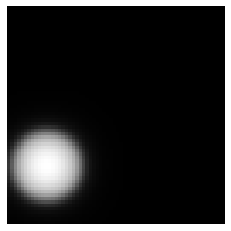

In [4]:
dataset.update().plot(cmap="gray") #This generates a new sequence and plots it
video=dataset.update().resolve() #This generates a new sequence and stores in in "video"

**Data processing**

In [1]:
def get_data(data_amount):
  frames = []

  for _ in range(data_amount):
    video = dataset.update().resolve() # Get a new sequence of frames
    for frame in video:
      frames.append(frame)

  return tf.stack(frames)

data_amount = 1000
# Generate new data and save to file
#ball_data = get_data(data_amount)
#np.save('ball_data.npy', ball_data)

ball_data = np.load('ball_data.npy') # Load already generated data

NameError: name 'np' is not defined

**TASK 1**

In [6]:
neck_width = 256 # for 16 filters in the last convolutional layer in encoder
filters = 16 
#neck_width = 128 # for 8 filters in the last convolutional layer in encoder
#filters = 8
#neck_width = 64 # for 4 filters in the last convolutional layer in encoder
#filters = 4

class Autoencoder(tf.keras.Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
      tf.keras.layers.Conv2D(64, (8, 8), padding='same', strides=(4, 4), activation='relu'),
      tf.keras.layers.Conv2D(filters, (4, 4), padding='same', strides=(4, 4), activation='relu'),
      tf.keras.layers.Flatten()
    ])

    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(neck_width, )),
      tf.keras.layers.Reshape(target_shape=(4, 4, filters)),
      tf.keras.layers.Conv2DTranspose(filters, (4, 4), strides=(4, 4), activation='relu', padding='same'),
      tf.keras.layers.Conv2DTranspose(64, (8, 8), strides=(4, 4), activation='relu', padding='same'),
      tf.keras.layers.Conv2D(1, (1, 1), activation='linear', padding='same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.encoder.build(input_shape=(None, 64, 64, 1))
autoencoder.encoder.summary()

autoencoder.decoder.build(input_shape=(None, neck_width))
autoencoder.decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        4160      
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 16)          16400     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
Total params: 20,560
Trainable params: 20,560
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 4, 4, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  

In [7]:
n_frames = len(ball_data) 
ratio = 0.8 # training data to validation/test data ratio
train_val_split = [int(n_frames*ratio), n_frames-int(n_frames*ratio)]

x_train, x_val = tf.split(ball_data, train_val_split)

print("Training data size:", x_train.shape)
print("Validation data size:", x_val.shape)


Training data size: (8000, 64, 64, 1)
Validation data size: (2000, 64, 64, 1)


Train

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            min_delta=0,
                                            patience=3,
                                            verbose=1,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=True)
autoencoder.fit(x_train, x_train,
                 batch_size=32,
                 epochs=10,
                 shuffle=True,
                 validation_data=(x_val, x_val),
                 callbacks=[callback])

autoencoder.save('autoencoder_'+str(neck_width))

Visualisation

In [1]:
autoencoder = tf.keras.models.load_model('autoencoder_256')
#autoencoder = tf.keras.models.load_model('autoencoder_128')
#autoencoder = tf.keras.models.load_model('autoencoder_64')

n = sequence_length  # how many digits we will display
rand_sequence = np.random.randint(len(x_val)/sequence_length)

seq_start = rand_sequence * sequence_length

org_frames = x_val[seq_start : seq_start + sequence_length]
encoded_imgs = autoencoder.encoder(org_frames).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.figure(figsize=(20, 4))
for i in range(sequence_length):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(tf.squeeze(org_frames[i]))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(tf.squeeze(decoded_imgs[i]))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

NameError: name 'tf' is not defined

**Task 2**

In [8]:
# Parameters
neck_width = 256

latent_dim = neck_width
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
filt_dim = latent_dim+2
seq_len = 9

In [17]:
def create_model():

  time_embd = Time2Vector(seq_len)

  attention_layer = TransformerEncoder(d_k, d_v, n_heads, ff_dim, filt_dim)

  in_seq = tf.keras.layers.Input(shape=(seq_len, neck_width))
  x = time_embd(in_seq)
  x = tf.keras.layers.Concatenate(axis=-1)([in_seq, x])
  x = attention_layer((x, x, x))
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(neck_width * 2, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Reshape((1, -1))(x)
  out = tf.keras.layers.Dense(neck_width, activation='relu')(x)

  model = tf.keras.Model(inputs=in_seq, outputs=out)
  model.compile(optimizer='adam', loss='mse')
  
  return model

model = create_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 9, 256)]     0           []                               
                                                                                                  
 time2_vector_8 (Time2Vector)   (None, 9, 2)         36          ['input_5[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 9, 258)       0           ['input_5[0][0]',                
                                                                  'time2_vector_8[0][0]']         
                                                                                                  
 transformer_encoder_24 (Transf  (None, 9, 258)      3313420     ['concatenate_2[0][0]',    

Data preperation

In [20]:
autoencoder = tf.keras.models.load_model('autoencoder_256')
x_encoded = autoencoder.encoder(ball_data)
print(x_encoded.shape)

X_bottle_mask = ~tf.equal(tf.range(1,x_encoded.shape[0]+1) % 10, 0)
Y_bottle_mask = tf.equal(tf.range(1,x_encoded.shape[0]+1) % 10, 0)

X_bottle = tf.boolean_mask(x_encoded, X_bottle_mask)
Y_bottle = tf.boolean_mask(x_encoded, Y_bottle_mask)
print(X_bottle.shape)
print(Y_bottle.shape)
X_bottle = tf.reshape(X_bottle, (int(X_bottle.shape[0]/9), 9, 256))
Y_bottle = tf.reshape(Y_bottle, (int(Y_bottle.shape[0]), 1, 256))
print(X_bottle.shape)
print(Y_bottle.shape)

X_train = X_bottle[:int(0.8*X_bottle.shape[0]),:,:]
Y_train = Y_bottle[:int(0.8*Y_bottle.shape[0]),:,:]
X_val   = X_bottle[int(0.8*X_bottle.shape[0]):,:,:]
Y_val   = Y_bottle[int(0.8*Y_bottle.shape[0]):,:,:]

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

ResourceExhaustedError: Exception encountered when calling layer "sequential" (type Sequential).

OOM when allocating tensor with shape[10000,64,64,1] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Cast]

Call arguments received:
  • inputs=tf.Tensor(shape=(10000, 64, 64, 1), dtype=float64)
  • training=False
  • mask=None

Training

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5',
                                                monitor='val_loss',
                                                save_best_only=True, 
                                                verbose=1)
model.fit(X_train, Y_train, 
                 batch_size=32,
                 epochs=10,
                 shuffle=True,
                 validation_data=(X_val, Y_val),
                 callbacks=[callback]
                 )

model.save('transformer_encoder')